# Wall detection

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [4]:
path = Path("data")
path.ls()

[PosixPath('data/walllabels'),
 PosixPath('data/images'),
 PosixPath('data/wallmasks')]

In [5]:
path_lbl = path/'walllabels'
path_img = path/'images'

# Data

In [6]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('data/images/P118_000_000.png'),
 PosixPath('data/images/P015_000_000.png'),
 PosixPath('data/images/P041_000_000.png')]

In [7]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('data/walllabels/P118_000_000.png'),
 PosixPath('data/walllabels/P015_000_000.png'),
 PosixPath('data/walllabels/P041_000_000.png')]

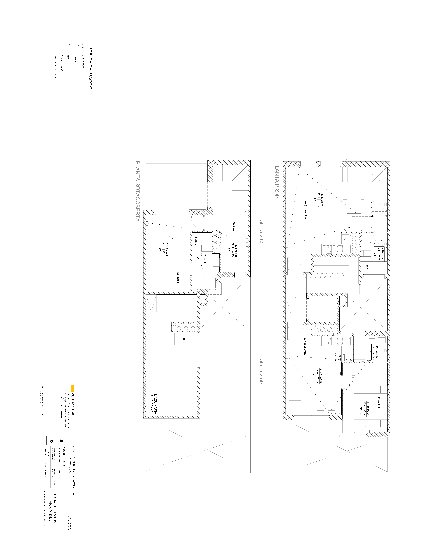

In [8]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(10,10))

In [9]:
get_y_fn = lambda x: path_lbl/f'{x.stem}{x.suffix}'

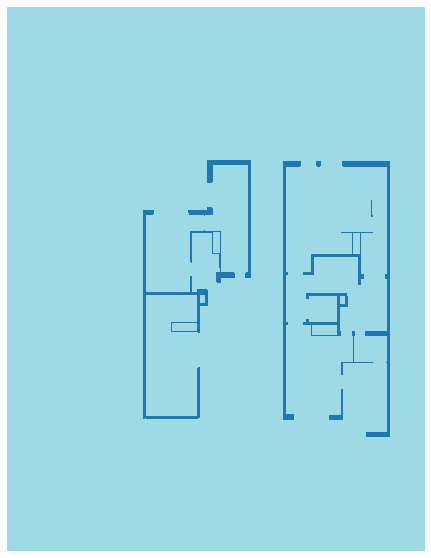

In [10]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(10,10), alpha=1)

In [11]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([7383, 5671]), tensor([[[1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          ...,
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1]]]))

In [12]:
codes = ['not-wall', 'wall']; codes

['not-wall', 'wall']

# Datasets

In [13]:
size = src_size//8
print(f"size: {size}")

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

size: [922 708]
using bs=4, have 4648MB of GPU RAM free


In [14]:
transforms = get_transforms(do_flip=True, flip_vert=True, max_rotate=90, max_zoom=2, p_affine=1)

In [15]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_rand_pct(valid_pct=0.1, seed=1)
       .label_from_func(get_y_fn, classes=codes))

In [16]:
data = (src.transform(transforms, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


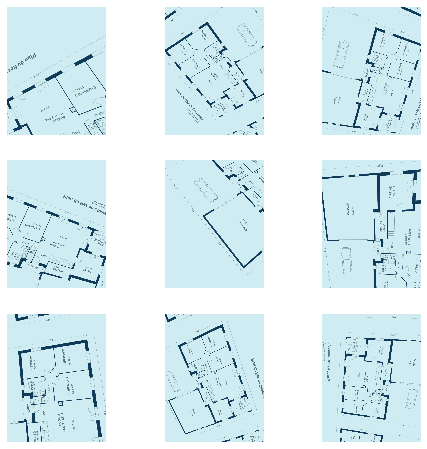

In [29]:
def _plot(i,j,ax):
    x,y = data.train_ds[1]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

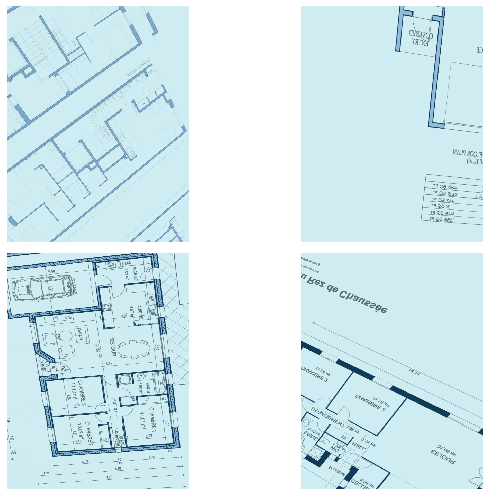

In [20]:
data.show_batch(3, figsize=(10,7))

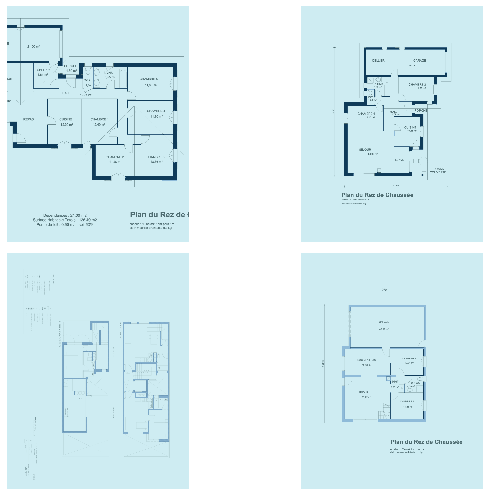

In [21]:
data.show_batch(3, figsize=(10,7), ds_type=DatasetType.Valid)

# Model

In [35]:
#name2id = {v:k for k,v in enumerate(codes)}
#void_code = name2id['Void']

#def acc_camvid(input, target):
#    target = target.squeeze(1)
#    mask = target != void_code
#    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()
def acc_wall(input, target):
    target = target.squeeze(1)
    mask = target != 0
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [36]:
metrics=acc_wall
# metrics=accuracy

In [37]:
wd=1e-2

In [38]:
def cuda_mem_usage():
    max_mem = torch.cuda.max_memory_allocated()
    mem = torch.cuda.memory_allocated()
    print(f"max_mem: {max_mem}, mem: {mem}")

In [39]:
cuda_mem_usage()
print(f"metrics: {metrics}, wd: {wd}")
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd).to_fp16()

max_mem: 0, mem: 0
metrics: <function acc_wall at 0x7f91d816a7b8>, wd: 0.01


max_mem: 7638884864, mem: 92604416


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


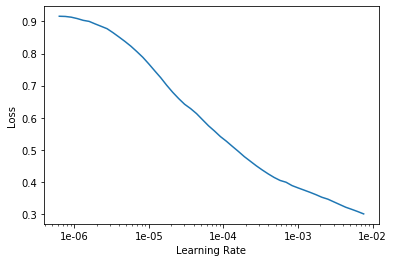

In [39]:
cuda_mem_usage()
lr_find(learn)
learn.recorder.plot()

In [40]:
cuda_mem_usage()

max_mem: 7644079616, mem: 415733248


In [41]:
lr=3e-4
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_wall,time
0,0.210446,0.069665,0.995350,00:29
1,0.129191,0.057486,0.998268,00:29
2,0.095331,0.041234,0.998164,00:31
3,0.072903,0.032430,0.997185,00:29
4,0.060329,0.027477,0.998530,00:28
5,0.052443,0.027151,0.997584,00:28
6,0.045068,0.035908,0.999507,00:29
7,0.042402,0.033355,0.998144,00:29
8,0.037941,0.022907,0.998944,00:28
9,0.033399,0.023031,0.998739,00:29


In [31]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_wall,time
0,0.090396,0.069577,0.995598,00:29
1,0.088578,0.068462,0.994954,00:30
2,0.083968,0.067681,0.995226,00:29
3,0.079303,0.061917,0.995891,00:28
4,0.077708,0.059745,0.996887,00:28
5,0.071962,0.057729,0.997634,00:29
6,0.068911,0.049272,0.994496,00:29
7,0.064928,0.051100,0.997736,00:26
8,0.061636,0.048643,0.997451,00:27
9,0.059243,0.046130,0.997387,00:29


In [25]:
learn.save('stage-1')

In [26]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (110 items)
x: SegmentationItemList
Image (3, 922, 708),Image (3, 922, 708),Image (3, 922, 708),Image (3, 922, 708),Image (3, 922, 708)
y: SegmentationLabelList
ImageSegment (1, 922, 708),ImageSegment (1, 922, 708),ImageSegment (1, 922, 708),ImageSegment (1, 922, 708),ImageSegment (1, 922, 708)
Path: data/images;

Valid: LabelList (12 items)
x: SegmentationItemList
Image (3, 922, 708),Image (3, 922, 708),Image (3, 922, 708),Image (3, 922, 708),Image (3, 922, 708)
y: SegmentationLabelList
ImageSegment (1, 922, 708),ImageSegment (1, 922, 708),ImageSegment (1, 922, 708),ImageSegment (1, 922, 708),ImageSegment (1, 922, 708)
Path: data/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d

In [50]:
# learn.destroy()
# learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd).to_fp16()
# learn.load('stage-1')

In [27]:
def show_results():
    n_valid = len(data.valid_ds)
    figsize = (15, n_valid*5)
    fig,axs = plt.subplots(n_valid, 3, figsize=figsize)
    for i,(x,y) in enumerate(data.valid_ds):
        x.show(ax=axs[i,0], figsize=(5,5))
        y.show(ax=axs[i,1], figsize=(5,5))
        pred, label, raw = learn.predict(x)
        pred.show(ax=axs[i,2], figsize=(5,5))

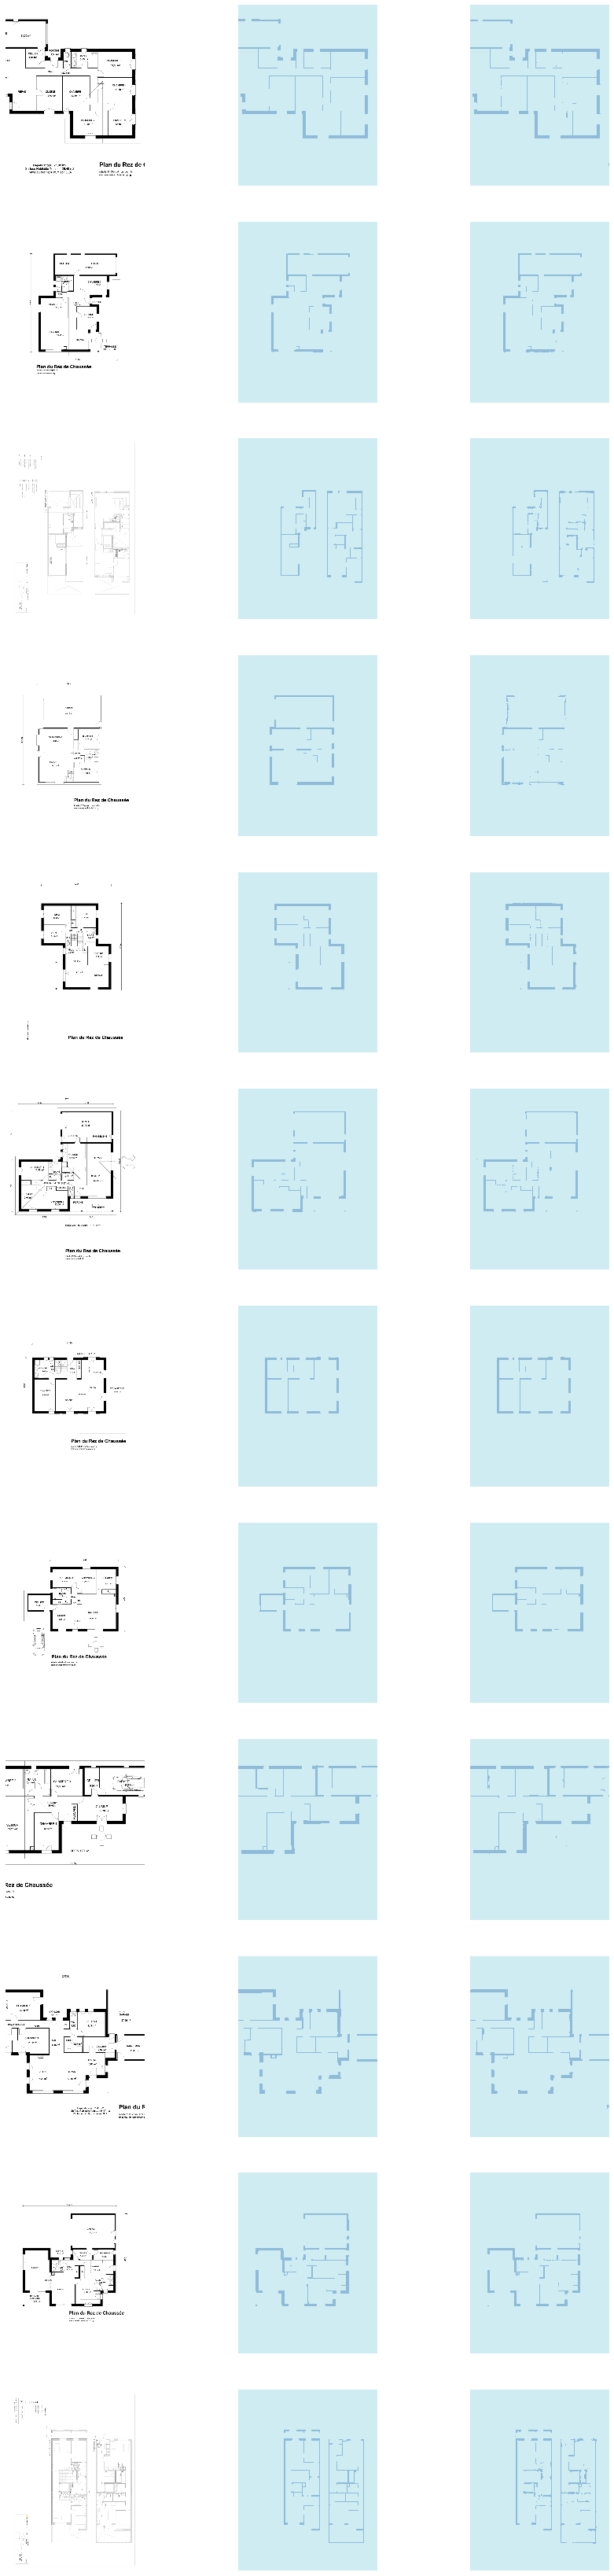

In [28]:
show_results()

In [29]:
learn.unfreeze()

In [30]:
lrs = slice(lr/400,lr/40)

In [31]:
learn.fit_one_cycle(5, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_wall,time
0,0.014622,0.014941,0.998155,00:29
1,0.014299,0.016934,0.998823,00:28
2,0.013912,0.016229,0.998563,00:28
3,0.013453,0.016781,0.998669,00:29
4,0.013400,0.015297,0.998365,00:31


In [32]:
learn.save('stage-2')

In [57]:
# learn.destroy()
# learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd).to_fp16()
learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (110 items)
x: SegmentationItemList
Image (3, 922, 708),Image (3, 922, 708),Image (3, 922, 708),Image (3, 922, 708),Image (3, 922, 708)
y: SegmentationLabelList
ImageSegment (1, 922, 708),ImageSegment (1, 922, 708),ImageSegment (1, 922, 708),ImageSegment (1, 922, 708),ImageSegment (1, 922, 708)
Path: data/images;

Valid: LabelList (12 items)
x: SegmentationItemList
Image (3, 922, 708),Image (3, 922, 708),Image (3, 922, 708),Image (3, 922, 708),Image (3, 922, 708)
y: SegmentationLabelList
ImageSegment (1, 922, 708),ImageSegment (1, 922, 708),ImageSegment (1, 922, 708),ImageSegment (1, 922, 708),ImageSegment (1, 922, 708)
Path: data/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d

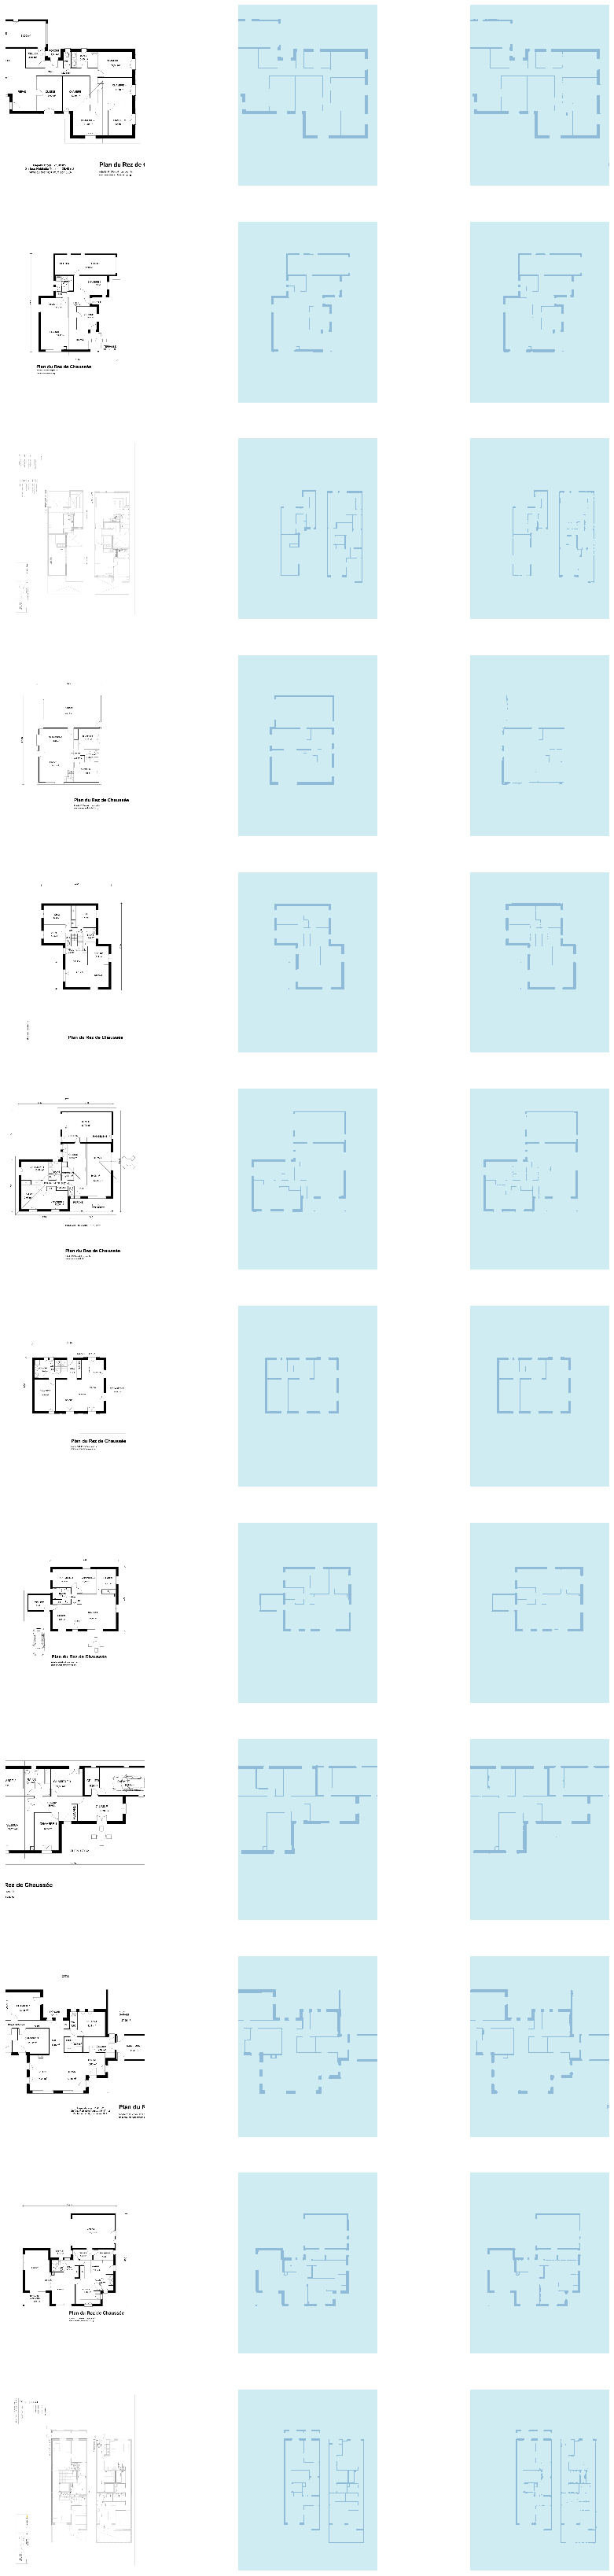

In [33]:
show_results()

# Manual convolutions

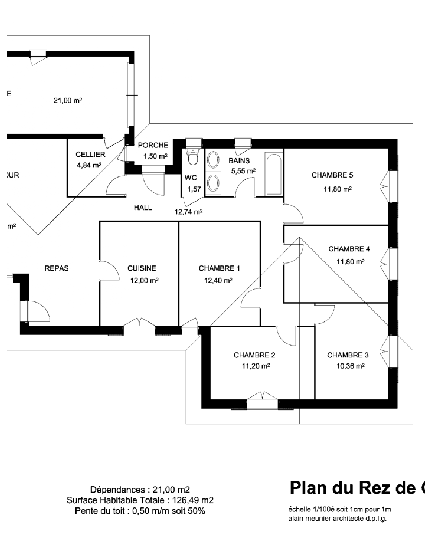

In [26]:
idx=0
x,y = data.valid_ds[idx]
x.show(figsize=(10,10))
#data.valid_ds.y[idx]

In [27]:
k = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(1,3,3,3)/6

In [28]:
k

tensor([[[[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]]]])

In [29]:
t = data.valid_ds[0][0].data; t.shape

torch.Size([3, 922, 708])

In [30]:
t[None].shape

torch.Size([1, 3, 922, 708])

In [31]:
edge = F.conv2d(t[None], k)

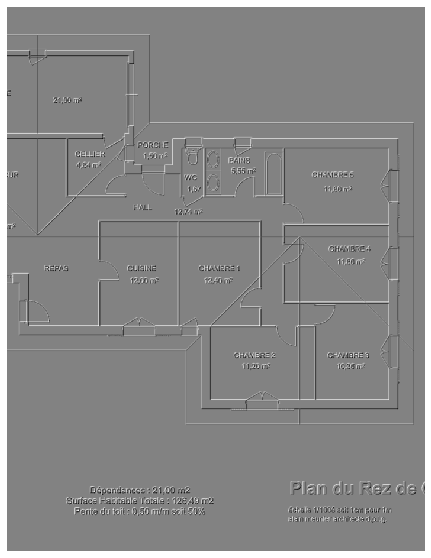

In [33]:
show_image(edge[0], figsize=(10,10));

# Activation visualisation

In [73]:
learn.load('stage-2')
learn_full = learn.to_fp32()
learn_full.summary()

DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 461, 354]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 461, 354]       128        True      
______________________________________________________________________
ReLU                 [64, 461, 354]       0          False     
______________________________________________________________________
MaxPool2d            [64, 231, 177]       0          False     
______________________________________________________________________
Conv2d               [64, 231, 177]       36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 231, 177]       128        True      
______________________________________________________________________
ReLU                 [64, 231, 177]       0          False     
__________________________________________________

In [75]:
m = learn_full.model.eval()

In [76]:
m[0]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [77]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [78]:
xb.shape

torch.Size([1, 3, 922, 708])

In [79]:
from fastai.callbacks.hooks import *

In [80]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            #preds[0,int(cat)].backward()
    return hook_a,hook_g

In [81]:
hook_a,hook_g = hooked_backward()

In [82]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 29, 23])

In [83]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([29, 23])

In [89]:
def show_heatmap(hm, figsize=(3,3)):
    _,ax = plt.subplots(figsize=figsize)
    xb_im.show(ax, figsize)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');

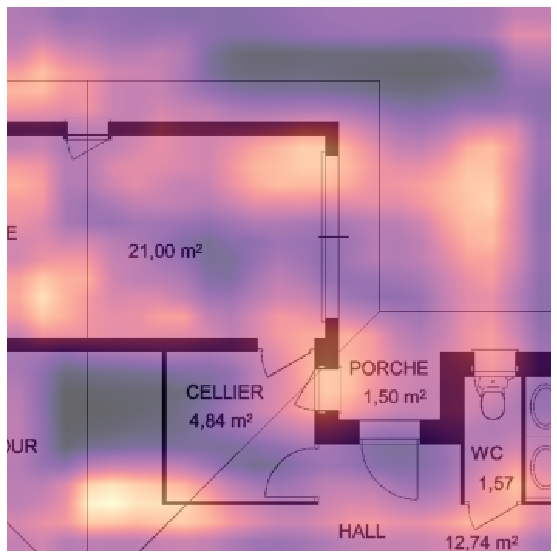

In [90]:
show_heatmap(avg_acts, figsize=(10,10))